In [1]:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('darkgrid')
%matplotlib inline
from sklearn.manifold import TSNE
nltk.download('wordnet')
import string
from  nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.collocations import *

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eduar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Preprocessing:

In [2]:
#Negative emotion = 0

#Positive emotion = 1
data = pd.read_csv('Data/Twitter_sentiment_processed.csv', encoding='latin1')
data

,Tweet,Subject_of_tweet,Emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1
...,...,...,...
3543,@mention your PR guy just convinced me to swit...,iPhone,1
3544,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,1
3545,Diller says Google TV &quot;might be run over ...,Other Google product or service,0
3546,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,1


In [3]:
#Dropped 'Subject of tweets' column
data.drop(columns=['Subject_of_tweet'], inplace=True)

In [4]:
#Looking at value counts
data['Emotion'].value_counts()

1    2978
0     570
Name: Emotion, dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tweet    3548 non-null   object
 1   Emotion  3548 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 55.6+ KB


In [6]:
#Changing the data type to str to make sure it can be tokenized
data['Tweet'] = data['Tweet'].astype('str')

In [7]:
# Splitting the target varible from the rest of the data set and dropped subject of tweet for the time being
y = data['Emotion']
X = data['Tweet']

## Train-Test Split:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

In [9]:
#created stop words list
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``', 'link', 'mention', 'sxsw', "'", "'s", "n't", 'rt']

In [10]:
#tokenized and lemmantized the tweets
def process_tweet(tweet):
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed 

In [11]:
processed_data = list(map(process_tweet, X_train))

In [12]:
processed_data[2]

["'re",
 'giving',
 'away',
 'ipad',
 '2',
 'creator',
 'popular',
 'disc',
 'interactive',
 'create',
 'disc',
 'amp',
 'share',
 'twitter']

In [13]:
#Count of total vocabulary
total_vocab = set()
for tweet in processed_data:
    total_vocab.update(tweet)
len(total_vocab)

5288

In [14]:
#Concating everything to look at frequency distributions
tweet_concat = []

for tweet in processed_data:
    tweet_concat += tweet

In [15]:
tweet_concat

['great',
 'blog',
 'latest',
 'news',
 'like',
 'opening',
 'apple',
 'store',
 'sxsw2011',
 'lovin',
 'digital',
 'band',
 'sings',
 'iphone',
 'amp',
 'play',
 'guitar',
 'app',
 'fan',
 'record',
 'vids',
 'ipad2s',
 'cnn',
 'digital',
 'cnngrill',
 'sxswi',
 "'re",
 'giving',
 'away',
 'ipad',
 '2',
 'creator',
 'popular',
 'disc',
 'interactive',
 'create',
 'disc',
 'amp',
 'share',
 'twitter',
 'ipad',
 '2',
 'thanks',
 'fxsw',
 'geogames',
 'android',
 'develop',
 'geo-games',
 'tweet',
 'u',
 "'d",
 'love',
 'talk',
 'free',
 'beer',
 'coffee',
 'couple',
 'minute',
 'time',
 'stock',
 'mophie',
 'juice',
 'pack',
 'apple',
 'temp',
 'store',
 'open',
 'austin',
 'amp',
 'ipad',
 '2',
 'launch',
 'via',
 'looking',
 'line',
 'pop',
 'apple',
 'store',
 'ca',
 'think',
 'single',
 'object',
 'want',
 'much',
 'love',
 'google',
 'analytics',
 'thanks',
 'follower',
 'took',
 'time',
 'check',
 'new',
 'post',
 'think',
 'fell',
 'bit',
 'love',
 'google',
 'today',
 'thanks',


In [16]:
#Looking at the top 200 most common words
tweet_freqdist = FreqDist(tweet_concat)
tweet_freqdist.most_common(200)

[('ipad', 944),
 ('apple', 834),
 ('google', 697),
 ('iphone', 549),
 ('quot', 502),
 ('store', 471),
 ('2', 453),
 ('app', 345),
 ('new', 309),
 ('austin', 263),
 ('amp', 178),
 ('android', 174),
 ('ipad2', 172),
 ('get', 170),
 ('launch', 155),
 ('time', 138),
 ('one', 137),
 ('line', 131),
 ('like', 125),
 ('party', 125),
 ('pop-up', 125),
 ('social', 121),
 ('circle', 120),
 ('great', 114),
 ('day', 114),
 ('free', 110),
 ('via', 106),
 ('today', 106),
 ("'m", 105),
 ('win', 102),
 ('map', 99),
 ('cool', 97),
 ('go', 94),
 ('people', 92),
 ('sxswi', 91),
 ('mobile', 91),
 ('apps', 87),
 ('come', 86),
 ('network', 85),
 ('good', 81),
 ('temporary', 81),
 ('love', 78),
 ('need', 77),
 ('awesome', 77),
 ('got', 77),
 ('u', 75),
 ('opening', 74),
 ("'re", 72),
 ('open', 71),
 ('downtown', 70),
 ('going', 69),
 ('see', 69),
 ('user', 69),
 ('even', 65),
 ('w/', 64),
 ('want', 62),
 ('check', 62),
 ('mayer', 62),
 ('thanks', 61),
 ('year', 61),
 ('think', 60),
 ('popup', 58),
 ('first', 

In [17]:
tweet_freq_50 = tweet_freqdist.most_common(50)
tweet_freq_50

[('ipad', 944),
 ('apple', 834),
 ('google', 697),
 ('iphone', 549),
 ('quot', 502),
 ('store', 471),
 ('2', 453),
 ('app', 345),
 ('new', 309),
 ('austin', 263),
 ('amp', 178),
 ('android', 174),
 ('ipad2', 172),
 ('get', 170),
 ('launch', 155),
 ('time', 138),
 ('one', 137),
 ('line', 131),
 ('like', 125),
 ('party', 125),
 ('pop-up', 125),
 ('social', 121),
 ('circle', 120),
 ('great', 114),
 ('day', 114),
 ('free', 110),
 ('via', 106),
 ('today', 106),
 ("'m", 105),
 ('win', 102),
 ('map', 99),
 ('cool', 97),
 ('go', 94),
 ('people', 92),
 ('sxswi', 91),
 ('mobile', 91),
 ('apps', 87),
 ('come', 86),
 ('network', 85),
 ('good', 81),
 ('temporary', 81),
 ('love', 78),
 ('need', 77),
 ('awesome', 77),
 ('got', 77),
 ('u', 75),
 ('opening', 74),
 ("'re", 72),
 ('open', 71),
 ('downtown', 70)]

In [18]:
class Percent(float):
    def __str__(self):
        return '{:.2%}'.format(self)

In [19]:
x = 3548
freq_percentage = [(t[0], t[1]/x) for t in tweet_freq_50]

In [20]:
freq_percentage

[('ipad', 0.266065388951522),
 ('apple', 0.2350620067643743),
 ('google', 0.1964487034949267),
 ('iphone', 0.15473506200676437),
 ('quot', 0.1414881623449831),
 ('store', 0.13275084554678693),
 ('2', 0.12767756482525366),
 ('app', 0.09723788049605411),
 ('new', 0.0870913190529876),
 ('austin', 0.07412626832018038),
 ('amp', 0.050169109357384445),
 ('android', 0.04904171364148816),
 ('ipad2', 0.048478015783540024),
 ('get', 0.047914317925591886),
 ('launch', 0.04368658399098083),
 ('time', 0.03889515219842165),
 ('one', 0.03861330326944758),
 ('line', 0.036922209695603156),
 ('like', 0.035231116121758735),
 ('party', 0.035231116121758735),
 ('pop-up', 0.035231116121758735),
 ('social', 0.03410372040586246),
 ('circle', 0.033821871476888386),
 ('great', 0.032130777903043965),
 ('day', 0.032130777903043965),
 ('free', 0.03100338218714769),
 ('via', 0.02987598647125141),
 ('today', 0.02987598647125141),
 ("'m", 0.02959413754227734),
 ('win', 0.02874859075535513),
 ('map', 0.027903043968432

In [21]:
#TF-IDF Vectorizing the tokens
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [22]:
tf_idf_data_train = vectorizer.fit_transform(X_train)

tf_idf_data_test = vectorizer.transform(X_test)

tf_idf_data_train.shape

(2838, 5429)

In [23]:
#Looking at sparse vectors
non_zero_cols = tf_idf_data_train.nnz / float(tf_idf_data_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tf_idf_data_train.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 16.634249471458773
Percentage of columns containing 0: 0.996936038041728


In [24]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

In [25]:
X_train_resampled, y_train_resampled = SMOTE().fit_resample(tf_idf_data_train, y_train)

In [26]:
print('Original dataset shape %s' % Counter(y_train_resampled))

Original dataset shape Counter({1: 2383, 0: 2383})


## Final Model:

In [27]:
#Running random forest and Naive Bayes to check models accuracy
rf_classifier = RandomForestClassifier(n_estimators=100)
nb_classifier = MultinomialNB()

In [28]:
#Fitting the classifiers
rf_classifier.fit(X_train_resampled, y_train_resampled)
rf_train_preds = rf_classifier.predict(X_train_resampled)
rf_test_preds = rf_classifier.predict(tf_idf_data_test)

In [29]:
rf_train_score = accuracy_score(y_train_resampled, rf_train_preds)
rf_test_score = accuracy_score(y_test, rf_test_preds)

print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))

Random Forest
Training Accuracy: 1.0 		 Testing Accuracy: 0.8761


In [30]:
nb_classifier.fit(X_train_resampled, y_train_resampled)
nb_train_preds = nb_classifier.predict(X_train_resampled)
nb_test_preds = nb_classifier.predict(tf_idf_data_test)

In [31]:
nb_train_score = accuracy_score(y_train_resampled, nb_train_preds)
nb_test_score = accuracy_score(y_test, nb_test_preds)

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))

Multinomial Naive Bayes
Training Accuracy: 0.9561 		 Testing Accuracy: 0.8183


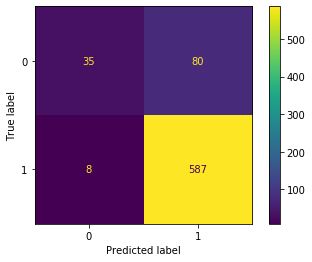

In [32]:
#Random Forest CLF
plot_confusion_matrix(rf_classifier, tf_idf_data_test, y_test, values_format='.3g')

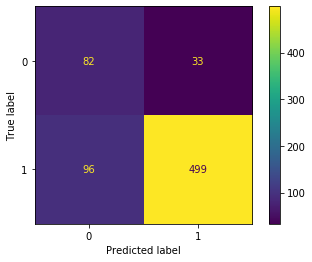

In [33]:
#Naive Bayes CLF
plot_confusion_matrix(nb_classifier, tf_idf_data_test, y_test, values_format='.3g')

## Feature Names:

In [34]:
rf_coefs = rf_classifier.feature_importances_.flatten()

In [35]:
nb_coefs = nb_classifier.coef_.flatten()

In [36]:
feature_names = vectorizer.get_feature_names()

In [37]:
#zipping coef and feature names together
zipped = zip(feature_names, rf_coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df1_pos = df.sort_values("abs_value", ascending=False)
df1_neg = df.sort_values("abs_value", ascending=True)

In [38]:
df1_neg

,feature,value,abs_value,colors
4877,toy,0.000000,0.000000,red
2615,james,0.000000,0.000000,red
1182,cried,0.000000,0.000000,red
3654,powering,0.000000,0.000000,red
526,basic,0.000000,0.000000,red
...,...,...,...,...
419,at,0.012873,0.012873,green
2597,is,0.013799,0.013799,green
3057,mention,0.014345,0.014345,green
4743,the,0.018023,0.018023,green


Text(0.5, 0, 'Feature Name')

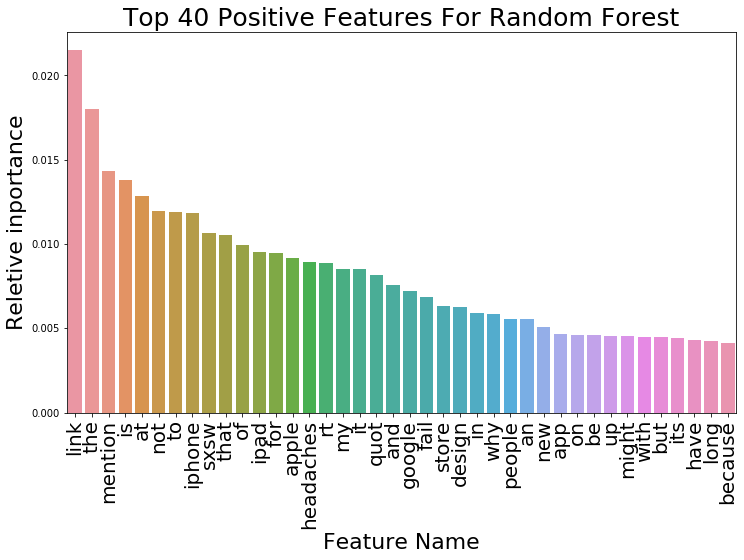

In [39]:
#Random Forest top 20 most important features
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df1_pos.head(40)
           )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 40 Positive Features For Random Forest", fontsize=25)
ax.set_ylabel("Reletive inportance", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

In [40]:
#zipping coef and feature names together
zipped2 = zip(feature_names, nb_coefs)
df2 = pd.DataFrame(zipped2, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df2["abs_value"] = df["value"].apply(lambda x: abs(x))
df2["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df2_pos = df.sort_values("abs_value", ascending=False)
df2_neg = df.sort_values("abs_value", ascending=True)

Text(0.5, 0, 'Feature Name')

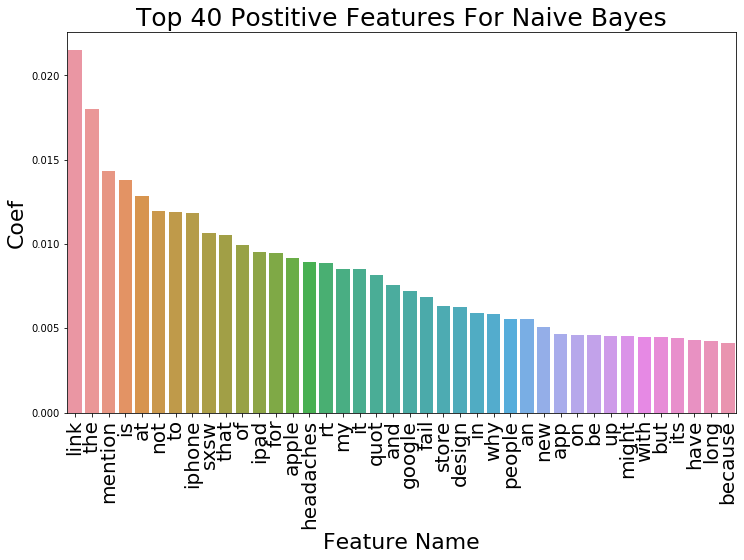

In [41]:
#Naive Bayes
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df2_pos.head(40)
           )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 40 Postitive Features For Naive Bayes", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

## Word Cloud:

In [42]:
df_freq_pos = data[data['Emotion']==1]
df_freq_neg = data[data['Emotion']==0]

In [43]:
pos_tweet = df_freq_pos['Tweet']
neg_tweet = df_freq_neg['Tweet']

In [44]:
positive_tweets = list(map(process_tweet, pos_tweet))
negative_tweets = list(map(process_tweet, neg_tweet))

In [45]:
total_tweet_pos = set()
for comment in positive_tweets:
    total_tweet_pos.update(comment)
len(total_tweet_pos)

5051

In [46]:
total_tweet_neg = set()
for comment in negative_tweets:
    total_tweet_neg.update(comment)
len(total_tweet_neg)

2020

In [47]:
#Positive tweets
print(positive_tweets[:2])

[['jessedee', 'know', 'fludapp', 'awesome', 'ipad/iphone', 'app', "'ll", 'likely', 'appreciate', 'design', 'also', "'re", 'giving', 'free', 't'], ['swonderlin', 'wait', 'ipad', '2', 'also', 'sale']]


In [48]:
#Negative Tweets
print(negative_tweets[:2])

[['wesley83', '3g', 'iphone', '3', 'hr', 'tweeting', 'rise_austin', 'dead', 'need', 'upgrade', 'plugin', 'station'], ['hope', 'year', 'festival', 'crashy', 'year', 'iphone', 'app']]


In [49]:
sentiment_pos = [item for sublist in positive_tweets for item in sublist]
sentiment_neg = [item for sublist in negative_tweets for item in sublist]

In [50]:
sentiment_pos_freq = FreqDist(sentiment_pos)
sentiment_neg_freq = FreqDist(sentiment_neg)

In [51]:
print('Most common Positve Sentiments Words')
sentiment_pos_freq.most_common(20)

Most common Positve Sentiments Words


[('ipad', 1002),
 ('apple', 925),
 ('google', 716),
 ('store', 554),
 ('iphone', 523),
 ('2', 503),
 ('quot', 464),
 ('app', 396),
 ('new', 359),
 ('austin', 294),
 ('amp', 211),
 ('ipad2', 209),
 ('android', 198),
 ('get', 180),
 ('launch', 174),
 ('pop-up', 151),
 ('one', 149),
 ('party', 148),
 ('line', 143),
 ('great', 137)]

In [52]:
print('Most common Negative Sentiments Words')
sentiment_neg_freq.most_common(20)

Most common Negative Sentiments Words


[('ipad', 188),
 ('quot', 175),
 ('iphone', 161),
 ('google', 145),
 ('apple', 120),
 ('2', 65),
 ('app', 60),
 ('store', 47),
 ('new', 43),
 ('like', 42),
 ('circle', 37),
 ('need', 35),
 ('social', 31),
 ('apps', 30),
 ('people', 29),
 ('design', 28),
 ('get', 25),
 ('android', 24),
 ('austin', 24),
 ('one', 23)]

In [53]:
#Positive tweets normalized frequency
positive_tweets_total_word_count = sum(sentiment_pos_freq.values())
positive_tweet_top_25 = sentiment_pos_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in positive_tweet_top_25:
    normalized_frequency = word[1]/positive_tweets_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

ipad 		 0.03321
apple 		 0.03065
google 		 0.02373
store 		 0.01836
iphone 		 0.01733
2 		 0.01667
quot 		 0.01538
app 		 0.01312
new 		 0.0119
austin 		 0.009743
amp 		 0.006993
ipad2 		 0.006926
android 		 0.006562
get 		 0.005965
launch 		 0.005766
pop-up 		 0.005004
one 		 0.004938
party 		 0.004905
line 		 0.004739
great 		 0.00454
time 		 0.00454
free 		 0.004143
social 		 0.004109
via 		 0.003977
cool 		 0.003977


In [54]:
#Negative tweets normalized frequency
negative_tweets_total_word_count = sum(sentiment_neg_freq.values())
negative_tweet_top_25 = sentiment_neg_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in negative_tweet_top_25:
    normalized_frequency = word[1]/negative_tweets_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

ipad 		 0.03116
quot 		 0.029
iphone 		 0.02668
google 		 0.02403
apple 		 0.01989
2 		 0.01077
app 		 0.009944
store 		 0.007789
new 		 0.007126
like 		 0.006961
circle 		 0.006132
need 		 0.0058
social 		 0.005138
apps 		 0.004972
people 		 0.004806
design 		 0.00464
get 		 0.004143
android 		 0.003977
austin 		 0.003977
one 		 0.003812
think 		 0.003812
time 		 0.003812
amp 		 0.003646
launch 		 0.003646
would 		 0.00348


In [55]:
# create counts of satire and not satire with values and words
positive_tweets_bar_counts = [x[1] for x in sentiment_pos_freq.most_common(25)]
positive_tweets_bar_words = [x[0] for x in sentiment_pos_freq.most_common(25)]

negative_tweets_bar_counts = [x[1] for x in sentiment_neg_freq.most_common(25)]
negative_tweets_bar_words = [x[0] for x in sentiment_neg_freq.most_common(25)]

In [56]:
from wordcloud import WordCloud
pos_tweet_dictionary = dict(zip(positive_tweets_bar_words, positive_tweets_bar_counts))
neg_tweet_dictionary = dict(zip(negative_tweets_bar_words, negative_tweets_bar_counts))

In [57]:
pos_tweet_dictionary

{'ipad': 1002,
 'apple': 925,
 'google': 716,
 'store': 554,
 'iphone': 523,
 '2': 503,
 'quot': 464,
 'app': 396,
 'new': 359,
 'austin': 294,
 'amp': 211,
 'ipad2': 209,
 'android': 198,
 'get': 180,
 'launch': 174,
 'pop-up': 151,
 'one': 149,
 'party': 148,
 'line': 143,
 'great': 137,
 'time': 137,
 'free': 125,
 'social': 124,
 'via': 120,
 'cool': 120}

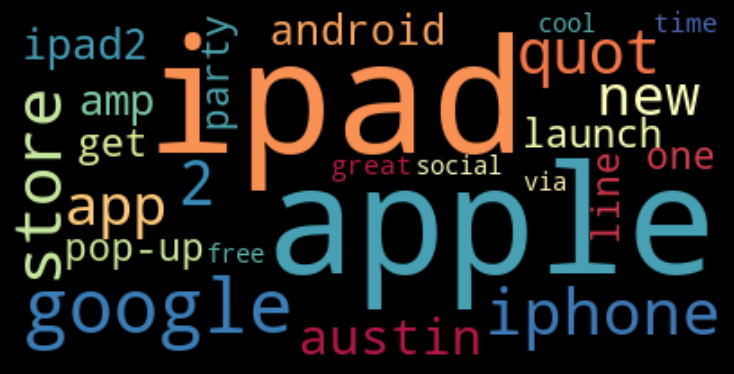

In [58]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(pos_tweet_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

plt.show()

## GridSearch:

In [59]:
rf_classifier = RandomForestClassifier()
parameters = {
     "n_estimators"    : [3, 5, 7],
     "criterion": ['gini', 'entropy'],
     "max_depth"        : [ 1, 2, 3],
     "min_samples_leaf" : [ 1, 3, 5],
     "min_weight_fraction_leaf" : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "max_leaf_nodes"   : [1, 2, 3, 5, 'None']
     }

grid = GridSearchCV(rf_classifier,
                    parameters, n_jobs=4,
                    scoring="recall",
                    cv=3,
                    return_train_score=True)

grid.fit(tf_idf_data_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3],
                         'max_leaf_nodes': [1, 2, 3, 5, 'None'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'n_estimators': [3, 5, 7]},
             return_train_score=True, scoring='recall')

In [60]:
#Looking for the most optimal parameters

# {'criterion': 'gini',
#  'max_depth': 3,
#  'max_leaf_nodes': 5,
#  'min_samples_leaf': 1,
#  'min_weight_fraction_leaf': 0.0,
#  'n_estimators': 5}
grid.best_params_ 

{'criterion': 'gini',
 'max_depth': 1,
 'max_leaf_nodes': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 3}

In [61]:
best_params = grid.best_params_ 

In [62]:
#taking a look at the most important features
grid.best_estimator_.feature_importances_

array([0., 0., 0., ..., 0., 0., 0.])

In [63]:
rf_classifier = RandomForestClassifier(**best_params)

rf_classifier.fit(X_train_resampled, y_train_resampled)
                             
rf_train_preds = rf_classifier.predict(X_train_resampled)
rf_test_preds = rf_classifier.predict(tf_idf_data_test)

Random Forest
Training Accuracy: 0.5646 		 Testing Accuracy: 0.8028


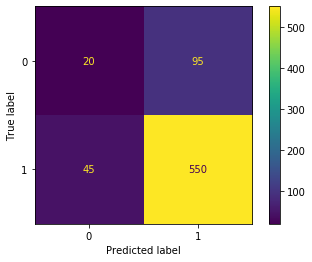

In [64]:
rf_train_score = accuracy_score(y_train_resampled, rf_train_preds)
rf_test_score = accuracy_score(y_test, rf_test_preds)
plot_confusion_matrix(rf_classifier, tf_idf_data_test, y_test, values_format='.3g')
print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))
